In [448]:
!pip install diffusers transformers accelerate scipy safetensors gdown

In [449]:
import PIL
import requests
import torch
from io import BytesIO

In [450]:
from diffusers import StableDiffusionInpaintPipeline

In [451]:

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float32,
)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

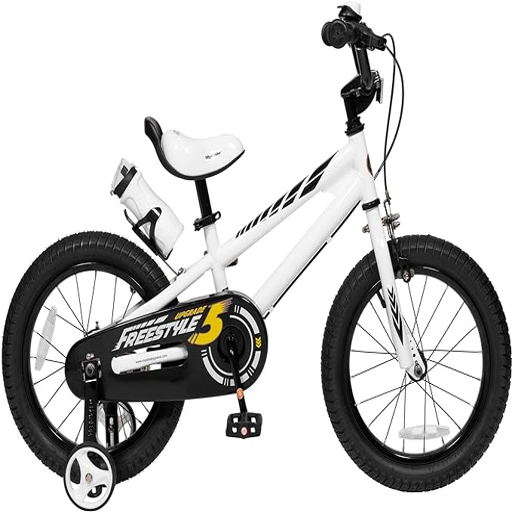

In [452]:
def download_image(url):
    
    return PIL.Image.open(url).convert("RGB")

img_url =r'/kaggle/input/avataar-example/Avataar_example/example2.jpg'
init_image = download_image(img_url)

init_image=init_image.resize((512,512))
init_image

In [453]:
init_image.size

(512, 512)

 ***Removing background***

In [454]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [455]:

!git clone https://github.com/xuebinqin/DIS

%cd ./DIS/IS-Net

Cloning into 'DIS'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (184/184), done.5% (102/184)
remote: Compressing objects: 100% (52/52), done.
remote: Total 361 (delta 159), reused 132 (delta 132), pack-reused 177 (from 1)
Receiving objects: 100% (361/361), 49.60 MiB | 7.30 MiB/s, done.
Resolving deltas: 100% (176/176), done.
/kaggle/working/DIS/IS-Net/DIS/IS-Net


In [456]:
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
import gdown
import os

import requests
import matplotlib.pyplot as plt
from io import BytesIO

# project imports
from data_loader_cache import normalize, im_reader, im_preprocess 
from models import *

In [457]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Download official weights
if not os.path.exists("./saved_models"):
    !mkdir ./saved_models
    MODEL_PATH_URL = r"https://drive.google.com/uc?id=1KjdN6oNpt7pKzn1DPQ7d0PtGEY0v8EYz"
    gdown.download(MODEL_PATH_URL, "./saved_models/isnet.pth", use_cookies=False)


class GOSNormalize(object):
    '''
    Normalize the Image using torch.transforms
    '''
    def __init__(self, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
        self.mean = mean
        self.std = std

    def __call__(self,image):
        image = normalize(image,self.mean,self.std)
        return image


transform =  transforms.Compose([GOSNormalize([0.5,0.5,0.5],[1.0,1.0,1.0])])

def load_image(im_path, hypar):
#     if im_path.startswith("http"):
#         im_path = BytesIO(requests.get(im_path).content)

    im = im_reader(im_path)
    im, im_shp = im_preprocess(im, hypar["cache_size"])
    im = torch.divide(im,255.0)
    shape = torch.from_numpy(np.array(im_shp))
    return transform(im).unsqueeze(0), shape.unsqueeze(0) # make a batch of image, shape


def build_model(hypar, device):
    net = hypar["model"]
    
    # Convert to half precision
    if hypar["model_digit"] == "half":
        net.half()
        for layer in net.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.float()

    net.to(device)

    if hypar["restore_model"] != "":
        # Load the model weights from the uploaded file
        net.load_state_dict(torch.load(os.path.join(hypar["model_path"], hypar["restore_model"]), map_location=device))
        
    net.eval()
    return net
    
def predict(net,  inputs_val, shapes_val, hypar, device):
    '''
    Given an Image, predict the mask
    '''
    net.eval()

    if(hypar["model_digit"]=="full"):
        inputs_val = inputs_val.type(torch.FloatTensor)
    else:
        inputs_val = inputs_val.type(torch.HalfTensor)

  
    inputs_val_v = Variable(inputs_val, requires_grad=False).to(device) # wrap inputs in Variable
   
    ds_val = net(inputs_val_v)[0] # list of 6 results

    pred_val = ds_val[0][0,:,:,:] # B x 1 x H x W    # we want the first one which is the most accurate prediction

    ## recover the prediction spatial size to the orignal image size
    pred_val = torch.squeeze(F.upsample(torch.unsqueeze(pred_val,0),(shapes_val[0][0],shapes_val[0][1]),mode='bilinear'))

    ma = torch.max(pred_val)
    mi = torch.min(pred_val)
    pred_val = (pred_val-mi)/(ma-mi) # max = 1

    if device == 'cuda': torch.cuda.empty_cache()
    return (pred_val.detach().cpu().numpy()*255).astype(np.uint8) # it is the mask we need

Downloading...
From (original): https://drive.google.com/uc?id=1KjdN6oNpt7pKzn1DPQ7d0PtGEY0v8EYz
From (redirected): https://drive.google.com/uc?id=1KjdN6oNpt7pKzn1DPQ7d0PtGEY0v8EYz&confirm=t&uuid=1b71f485-b95a-4372-b727-bfba9c88964a
To: /kaggle/working/DIS/IS-Net/DIS/IS-Net/saved_models/isnet.pth
100%|██████████| 177M/177M [00:03<00:00, 48.2MB/s] 


In [458]:
hypar = {} # paramters for inferencing


hypar["model_path"] ="./saved_models" ## load trained weights from this path
hypar["restore_model"] = "isnet.pth" ## name of the to-be-loaded weights
hypar["interm_sup"] = False ## indicate if activate intermediate feature supervision

##  choose floating point accuracy --
hypar["model_digit"] = "full" ## indicates "half" or "full" accuracy of float number
hypar["seed"] = 0

hypar["cache_size"] = [1024, 1024] ## cached input spatial resolution, can be configured into different size

## data augmentation parameters ---
hypar["input_size"] = [1024, 1024] ## mdoel input spatial size, usually use the same value hypar["cache_size"], which means we don't further resize the images
hypar["crop_size"] = [1024, 1024] ## random crop size from the input, it is usually set as smaller than hypar["cache_size"], e.g., [920,920] for data augmentation

hypar["model"] = ISNetDIS()

In [459]:
net = build_model(hypar, device)

/tmp/ipykernel_30/2925136568.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(os.path.join(hypar["model_path"], hypar["restore_model"]), m

In [460]:
from PIL import Image
from io import BytesIO

def pil_to_bytesio(pil_image):
    byte_io = BytesIO()
    
    pil_image.save(byte_io, format='JPEG')  
    
    byte_io.seek(0)
    
    return byte_io


# Now you can use image_bytesio in your code


In [461]:
import cv2
import numpy as np
from PIL import Image

def erode_image(image, kernel_size=(2, 2), iterations=0):
    # Create a structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    
    eroded_image = cv2.erode(image, kernel, iterations=iterations)
    
    # Invert the eroded image
    eroded_image = cv2.bitwise_not(eroded_image)
    
    # Convert to PIL format in mode 'L'
#     pil_image = Image.fromarray(eroded_image).convert('L')
    
    return eroded_image


In [462]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def clean_binary_mask_with_blur(mask_image,j=10, kernel_size=(2, 2), blur_kernel=(5, 5)):
 
    kernel = np.ones(kernel_size, np.uint8)

#     mask_cleaned = cv2.morphologyEx(mask_image, cv2.MORPH_OPEN, kernel)

#     mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

    _, mask_binary = cv2.threshold(mask_cleaned, j, 255, cv2.THRESH_BINARY)
    
    return mask_binary



In [463]:
def create_object_mask(image):
    from PIL import Image, ImageFilter
    import matplotlib.pyplot as plt
    image_bytes = pil_to_bytesio(image)

    image_tensor, orig_size = load_image(image_bytes, hypar) 
    mask_temp_cleaned = predict(net, image_tensor, orig_size, hypar, device)
    # Clean the binary mask
#     mask_temp_cleaned = clean_binary_mask_with_blur(mask_temp_cleaned,50)
#
    mask_temp_cleaned=erode_image(mask_temp_cleaned,(2,2),2)
#     
#     mask_temp_cleaned = clean_binary_mask_with_blur(mask_temp_cleaned,210)
#     mask_temp_cleaned = cv2.bitwise_not(mask_temp_cleaned)
    e_mask = Image.fromarray(mask_temp_cleaned ).convert('L')
#     e_mask = e_mask.filter(ImageFilter.GaussianBlur(2))
    return  e_mask 

/tmp/ipykernel_30/2925136568.py:74: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  pred_val = torch.squeeze(F.upsample(torch.unsqueeze(pred_val,0),(shapes_val[0][0],shapes_val[0][1]),mode='bilinear'))


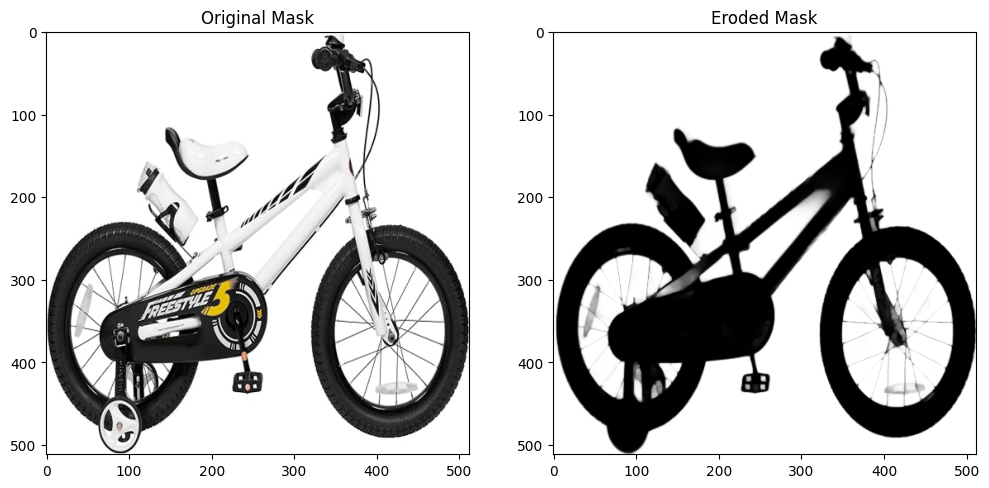

In [464]:
mask_image=create_object_mask(init_image)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Mask")
plt.imshow(init_image)

plt.subplot(1, 2, 2)
plt.title("Eroded Mask")
plt.imshow(mask_image, cmap='gray')

plt.show()

In [465]:
import matplotlib.pyplot as plt
def pair_display(image1,image2):
    plt.figure(figsize=(15, 9))

    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Orignal Image')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(image2,cmap='gray')
    plt.title('Mask Image')
    plt.axis('on')

    plt.show()

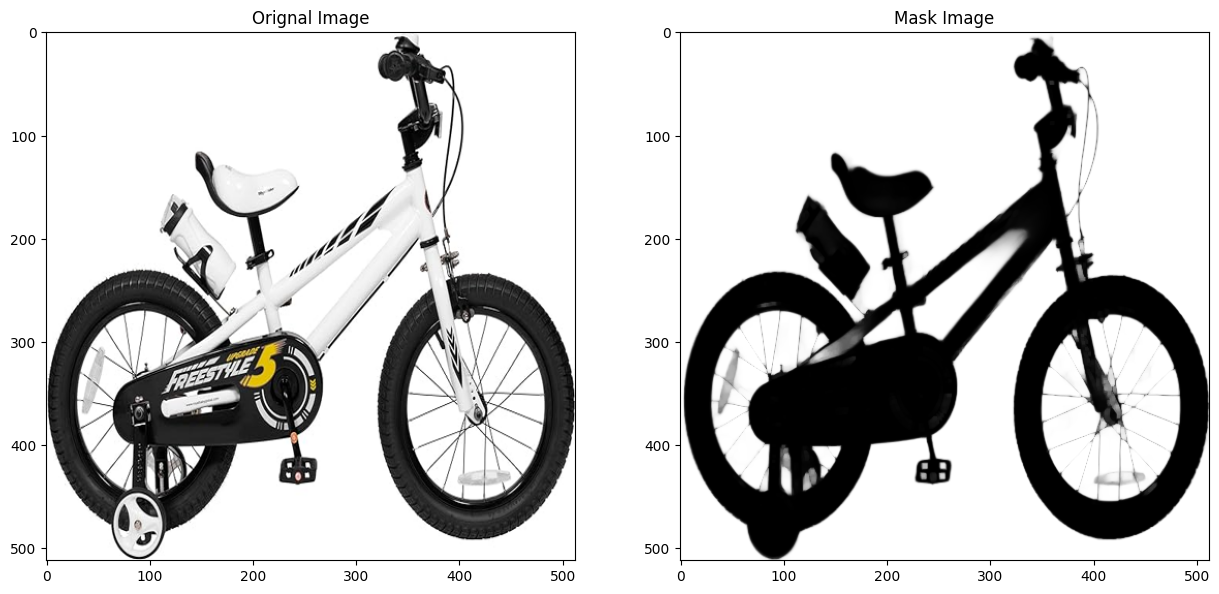

In [466]:
pair_display(init_image,mask_image)

In [467]:
# Import necessary libraries
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image

# Load the depth estimation model and feature extractor
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
depth_model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to("cuda")

# Function to generate depth map
def generate_depth_map(image):
    # Preprocess the input image
    inputs = feature_extractor(images=image, return_tensors="pt").to("cuda")
    
    # Generate the depth map using the model
    with torch.no_grad():
        depth_output = depth_model(**inputs).predicted_depth
    
    # Resize the depth map to match the input image size
    depth_map = torch.nn.functional.interpolate(
        depth_output.unsqueeze(1), 
        size=image.size[::-1],  # PIL image size is in (width, height), so reverse the dimensions
        mode="bicubic",
        align_corners=False
    ).squeeze()

    # Normalize the depth map for visualization and use
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    
    # Convert the depth map to a PIL image for further processing
    depth_map_image = Image.fromarray((depth_map.cpu().numpy() * 255).astype(np.uint8))
    
    return depth_map_image





Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


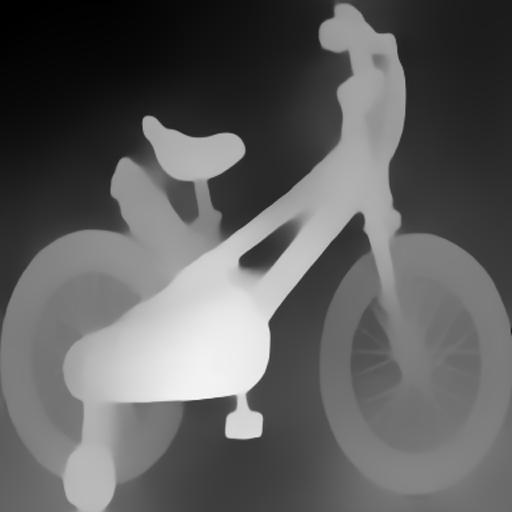

In [468]:

from PIL import Image

# Open the two images
def depth_map_image_fun(mask_image,init_image):
    depth_map_image = generate_depth_map(init_image)
    background = depth_map_image
    overlay = mask_image

    # Ensure the overlay image is the same size as the background (optional)
    overlay = overlay.resize(background.size)

    # Paste the overlay image onto the background with transparency (if needed)
    background.paste(overlay, (0, 0), overlay)
    return background


# Show the result
depth_map_image = generate_depth_map(init_image)
# depth_map_image=depth_map_image_fun(mask_image,init_image)
depth_map_image

  0%|          | 0/400 [00:00<?, ?it/s]

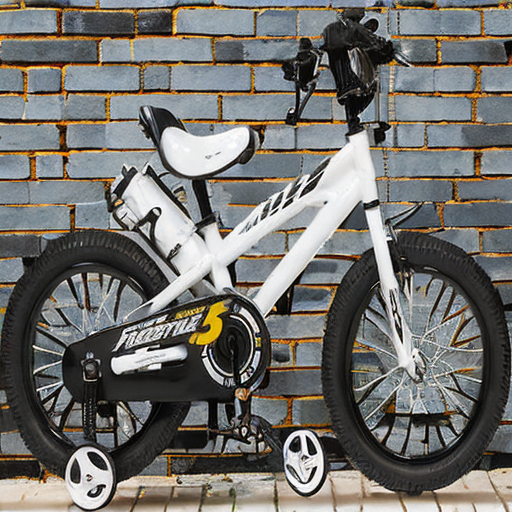

In [475]:
from PIL import Image
prompt ="A item on road  and old brown brick wall in natural sunlight "

negative_prompt="do not extend item No harsh lighting, no clutter no reflections, no unrealistic colors, no futuristic elements, no distorted shapes, no blurry objects, no floating items, no extreme highlights, no over-saturated colors, no chaotic composition,, no excessive details,do not change bicycle do not add extra part on  bicycle ."
# mask_image=mask_image.convert("RGB")
# Optimized hyperparameters
num_inference_steps = 500  # Refined image generation steps
guidance_scale = 8.5      # Balance between creativity and prompt adherence
# strength = 0.7           
# Generate inpainted image
new_image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=init_image,
    mask_image=mask_image,
    depth_map=depth_map_image,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,

).images[0]
new_image


In [470]:
print("Init Image Properties:")
print("Size:", init_image .size)
print("Mode:", init_image .mode)

# Check properties of output_image
print("mask Image Properties:")
print("Size:", mask_image .size)
print("Mode:", mask_image .mode)
print("Output Image Properties:")
print("Size:",new_image .size)
print("Mode:", new_image .mode)

Init Image Properties:
Size: (512, 512)
Mode: RGB
mask Image Properties:
Size: (512, 512)
Mode: L
Output Image Properties:
Size: (512, 512)
Mode: RGB


In [471]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


def resize_and_center_images(init_image, scale_factor=0.96):
    # Convert images to NumPy arrays if they are PIL Images
    item_img = np.array(init_image) if isinstance(init_image, Image.Image) else init_image

    # Resize the item image
    new_size = (int(item_img.shape[1] * scale_factor), int(item_img.shape[0] * scale_factor))
    resized_item = cv2.resize(item_img, new_size)

    # Create a white background with the same size as the original image
    background = np.ones_like(item_img) * 255

    # Calculate the position to place the resized item (center it)
    start_x = (background.shape[1] - resized_item.shape[1]) // 2
    start_y = (background.shape[0] - resized_item.shape[0]) // 2

    # Place the resized item on the white background
    background[start_y:start_y + resized_item.shape[0], start_x:start_x + resized_item.shape[1]] = resized_item
    resized_image=background

    # Return the processed image
    return resized_image






In [472]:
video_prompts = [
    "A vintage bicycle resting on a wooden pier, surrounded by calm water. Add depth using a depth map and smooth tires. The scene is serene, featuring gentle waves and soft sunlight reflecting on the water, harmonizing the bicycle with the tranquil background.", 
    "A bright red bicycle parked under a blooming cherry blossom tree. Add depth using a depth map and smooth tires. The atmosphere is peaceful, with delicate petals falling softly and subtle shadows playing on the ground, creating a harmonious background.",
    "A bicycle on a cobblestone street, illuminated by street lamps at dusk. Add depth using a depth map and smooth tires. The scene is nostalgic, with warm lights and gentle shadows enhancing the bicycle's details, harmonizing it with the charming street.",
    "A classic bicycle in a vibrant flower garden. Add depth using a depth map and smooth tires. The setting is cheerful and colorful, with various flowers around, creating a soft focus effect that harmonizes the bicycle with its beautiful surroundings.",
    "A bicycle against a rustic barn backdrop during golden hour. Add depth using a depth map and smooth tires. The scene is warm and inviting, with soft golden light bathing the bicycle and barn, enhancing the peaceful rural atmosphere.",
    "A bicycle on a mountain trail with lush greenery. Add depth using a depth map and smooth tires. The atmosphere is fresh and invigorating, with sunlight filtering through the trees and gentle shadows adding dimension to the scene.",
    "A bicycle parked beside a tranquil lake surrounded by mountains. Add depth using a depth map and smooth tires. The scene is serene, with calm waters reflecting the mountains, creating a peaceful harmony with the bicycle in focus.",
    "A bicycle on a rainy street, reflecting colorful lights. Add depth using a depth map and smooth tires. The scene is moody and atmospheric, with rain droplets creating a soft sheen on the ground, harmonizing the bicycle with its surroundings.",
    "A bicycle in a cozy coffee shop with large windows. Add depth using a depth map and smooth tires. The atmosphere is warm and inviting, with soft lighting illuminating the bicycle, creating a sense of calmness and harmony.",
    "A bicycle near a quaint bridge over a small stream. Add depth using a depth map and smooth tires. The setting is peaceful, with gentle water flow and greenery surrounding the bridge, harmonizing beautifully with the bicycle.",
    "A bicycle on a snowy path in a winter wonderland. Add depth using a depth map and smooth tires. The scene is magical, with soft snowflakes falling and subtle shadows enhancing the tranquil winter landscape around the bicycle.",
    "A bicycle resting on a grassy hill overlooking a city skyline. Add depth using a depth map and smooth tires. The atmosphere is expansive and vibrant, with the sunset casting a warm glow over the city, harmonizing with the bicycle's position.",
    "A bicycle by an old stone fountain in a quiet plaza. Add depth using a depth map and smooth tires. The scene is tranquil, with the sound of water and gentle sunlight filtering through trees, creating a peaceful harmony with the bicycle.",
    "A bicycle on a narrow path through a dense forest. Add depth using a depth map and smooth tires. The atmosphere is enchanting, with dappled sunlight breaking through leaves, enhancing the natural beauty and harmonizing the bicycle with the setting.",
    "A bicycle parked in front of a colorful mural on a brick wall. Add depth using a depth map and smooth tires. The scene is vibrant and artistic, with bright colors creating a lively background that harmonizes with the bicycle."
]

video_negative_prompt="No harsh lighting, no clutter,  no reflections, no unrealistic colors, no futuristic elements, no distorted shapes, no blurry objects, no floating items, no extreme highlights, no over-saturated colors, no chaotic composition,, no excessive details,do not change bicycle do not add extra part on  bicycle ."


In [473]:
import cv2
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# Updated function to handle multiple prompts
def frame_creation(init_image, prompts, negative_prompt, scale_factor=0.77):
    frames = []
    guidance_scale = 8.5     
    strength = 0.9   

    for prompt in prompts:
        # 1. First generate the image at original size for the current prompt
        scaled_image = init_image
        
        if isinstance(scaled_image, np.ndarray):
            scaled_image = Image.fromarray(scaled_image)

        # Apply inpainting with the original size for the current prompt
        mask_image_resized = create_object_mask(scaled_image)
        depth_map_resized=generate_depth_map(scaled_image)
        new_image_original = pipe(
            prompt=prompt, 
            negative_prompt=negative_prompt,
            image=scaled_image, 
            depth_map=depth_map_resized,
            mask_image=mask_image_resized, 
            num_inference_steps=500,
            guidance_scale=guidance_scale,
        ).images[0]
        
        # Append the original size frame
        frames.append(cv2.cvtColor(np.array(new_image_original), cv2.COLOR_RGB2BGR))

        # 2. Now resize the image by the scale factor (e.g., 0.77)
        scaled_image = resize_and_center_images(init_image, scale_factor)

        if isinstance(scaled_image, np.ndarray):
            scaled_image = Image.fromarray(scaled_image)

        # Apply inpainting with the scaled image for the same prompt
        mask_image_resized = create_object_mask(scaled_image)
        new_image_resized = pipe(
            prompt=prompt, 
            negative_prompt=negative_prompt,
            image=scaled_image,
            depth_map=depth_map_resized,             
            mask_image=mask_image_resized, 
            num_inference_steps=500,
            guidance_scale=guidance_scale,
        ).images[0]
        
        # Append the resized frame
        frames.append(cv2.cvtColor(np.array(new_image_resized), cv2.COLOR_RGB2BGR))
    
    return frames

# Generate frames for each prompt with scaling
frames = frame_creation(init_image, video_prompts, video_negative_prompt, scale_factor=0.77)


num_frames = len(frames)
cols = 4  # Number of columns
rows = (num_frames // cols) + (1 if num_frames % cols else 0)  # Determine rows based on frame count

fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
axes = axes.flatten()

# Display the frames
for i, frame in enumerate(frames):  # Adjust the number of displayed frames based on your grid size
    axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR back to RGB for display
    axes[i].axis('off')
    axes[i].set_title(f'Frame {i+1}')

plt.tight_layout()
plt.show()


/tmp/ipykernel_30/2925136568.py:74: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  pred_val = torch.squeeze(F.upsample(torch.unsqueeze(pred_val,0),(shapes_val[0][0],shapes_val[0][1]),mode='bilinear'))


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

# def save_frames_to_video(frames, output_path, fps=1, target_size=(512, 512)):
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     video_writer = cv2.VideoWriter(output_path, fourcc, fps, target_size)

#     for frame in frames:
#         video_frame = cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR)
#         video_writer.write(cv2.resize(video_frame, target_size))  # Ensure consistent size

#     video_writer.release()

# output_video_path = "/kaggle/working/output_video_4oct_afternoon.mp4"  # Change this to your desired output path
# save_frames_to_video(frames, output_video_path, fps=1)
# print(f"Video saved at {output_video_path}")
# from IPython.display import FileLink

# FileLink(output_video_path)

In [ ]:
import cv2
import numpy as np

def save_frames_to_video(frames, output_path='/kaggle/working/output_video.mp4', fps=1, video_size=(512, 512)):
    # Define the video codec and output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, video_size)

    for frame in frames:
        # Convert the frame to BGR format for OpenCV
        video_frame = cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR)

        # Get the size of the frame
        h, w, _ = video_frame.shape

        # Calculate the average color of the frame
        avg_color_per_row = np.average(video_frame, axis=0)
        avg_color = np.average(avg_color_per_row, axis=0).astype(int)
        avg_color = tuple(avg_color[::-1])  # Convert from BGR to RGB

        # Create a blank canvas with the target video size using the average color
        canvas = np.full((video_size[1], video_size[0], 3), avg_color, dtype=np.uint8)

        # Calculate the top-left corner to place the frame on the canvas to center it
        x_offset = (video_size[0] - w) // 2
        y_offset = (video_size[1] - h) // 2

        # Place the frame in the center of the canvas, keeping its original size
        canvas[y_offset:y_offset + h, x_offset:x_offset + w] = video_frame

        # Write the frame to the video
        video_writer.write(canvas)

    # Release the video writer
    video_writer.release()

    print(f"Video saved at {output_path}")

save_frames_to_video(frames, output_path='/kaggle/working/output_video.mp4')
